# DPA Calculation
### Liam Hughes

<div class="alert alert-block alert-info"> This uses the Pysrim package to run SRIM calculations </div>



In [27]:
#pip install pysrim
#pip install --upgrade pyyaml==5.4.1 #to get the package working
import srim
import sys
print("Python version")
print (sys.version)
print("Version info.")
print (sys.version_info)
import os

import numpy as np
import matplotlib.pyplot as plt

from srim import TRIM, Ion, Layer, Target
from srim.output import Results

import os
from collections import Counter
from itertools import count
from random import randint
from pathlib import Path
import math
# Specify the directory of SRIM.exe
# For windows users the path will include C://...
#SRIM on desktop
srim_executable_directory = 'C:/Users/peppe/Desktop/SRIM'
print('SRIM Location =', srim_executable_directory)
output_directory = 'C:/Users/peppe/Desktop/SRIM_Output/G91/run_'
print(output_directory)

#Some displacement energies for popular elements
from enum import Enum
class E_d(Enum):
    #Elements
    C = 69
    Si = 37
    Cr = 40
    Mn = 33
    Fe = 40
    Ni = 33
    Mo = 65
    W = 90
    Nb = 78
    V = 57
    #Some more...
    Al = 27
    Mg = 20
    P = 20
    S = 20
    Ti = 30
    Co = 36
    Cu = 30
    Y = 36
    Zr = 40

Python version
3.6.10 |Anaconda, Inc.| (default, May  7 2020, 19:46:08) [MSC v.1916 64 bit (AMD64)]
Version info.
sys.version_info(major=3, minor=6, micro=10, releaselevel='final', serial=0)
SRIM Location = C:/Users/peppe/Desktop/SRIM
C:/Users/peppe/Desktop/SRIM_Output/G91/run_


<div class="alert alert-block alert-danger"> If there is an error loading Pysrim, try and downgrade the version of Pyyaml. Using <b>pip install --upgrade pyyaml==5.4.1</b> to get the package working</div>

In [28]:
# G91 Steel SRIM Calculation
ion = Ion('H', energy=2.9e6)
width = 40 # um


# Construct a layer of G91 steel, 40um thick
G91 = Layer({
        'Fe': {
            'stoich': 88.58,
            'E_d': E_d.Fe.value,
            'lattice': 0.0,
            'surface': 0
        }
        ,'C': {
            'stoich': 0.12,
            'E_d': E_d.C.value,
            'lattice': 0.0,
            'surface': 0
        },'Cr': {
            'stoich': 9.5,
            'E_d': E_d.Cr.value,
            'lattice': 0.0,
            'surface': 0
        }
        ,'Mo': {
            'stoich': 1.05,
            'E_d': E_d.Mo.value,
            'lattice': 0.0,
            'surface': 0
        }
        ,'Ni': {
            'stoich': 0.4,
            'E_d': E_d.Ni.value,
            'lattice': 0.0,
            'surface': 0
        }
        ,'V': {
            'stoich': 0.25,
            'E_d': E_d.V.value,
            'lattice': 0.0,
            'surface': 0
        }
        ,'Nb': {
            'stoich': 0.1,
            'E_d': E_d.Nb.value,
            'lattice': 0.0,
            'surface': 0
        }
        }, density=7.874, width=width*10000, name='G91')

trim_settings = {
    'calculation': 1, # 1 = Quick KP Calc ,2 = full cascade
    #'collisions': 2,
    # 'angle_ions': 30
} 

# Construct a target of a single layer
target = Target([G91]) #can add more layers in array form

# Initialize a TRIM calculation with given target and ion for 99999 ions, quick calculation - see trim_settings

trim = TRIM(target, ion, number_ions=9999, **trim_settings)
results = trim.run(srim_executable_directory)

In [26]:
os.makedirs(output_directory, exist_ok=True)
TRIM.copy_output_files(srim_executable_directory, output_directory)

<div class="alert alert-block alert-info"> This code can automate SRIM calculations, by running with a range of energies </div>

In [32]:
#Loop through different energies
for i in range(1,11):
    trim = TRIM(target, Ion('H', energy=i*1e6), number_ions=99999, **trim_settings)
    results = trim.run(srim_executable_directory)
    os.makedirs(output_directory+str(i)+'MeV', exist_ok=True)
    TRIM.copy_output_files(srim_executable_directory, output_directory+str(i)+'MeV')

This is the analysis of the SRIM calculation

In [18]:
H_2_9MeV = 'C:/Users/peppe/Desktop/SRIM_Output/G91/2.9MeV'
H_3MeV = 'C:/Users/peppe/Desktop/SRIM_Output/G91/auto_3MeV'
H_4MeV = 'C:/Users/peppe/Desktop/SRIM_Output/G91/auto_4MeV'
H_5MeV = 'C:/Users/peppe/Desktop/SRIM_Output/G91/5MeV'
H_7MeV = 'C:/Users/peppe/Desktop/SRIM_Output/G91/7MeV'
H_36MeV = 'C:/Users/peppe/Desktop/SRIM_Output/G91/36MeV'

folders = [H_2_9MeV,H_4MeV,H_5MeV,H_7MeV,H_36MeV] #output_directory ###
folders = [H_2_9MeV] #output_directory ###
energies = ['2.9 MeV','3 MeV', '4 MeV', '5 MeV', '7 MeV','36 MeV'] ###

# folders = []
# energies = []
# for i in range(1,11):
#     folders.append(output_directory+str(i)+'MeV')
#     energies.append(str(i)+'MeV')

image_directory = 'C:/Users/peppe/Desktop/SRIM_images'
os.makedirs(image_directory, exist_ok=True)

def plot_dpa(folder, ax, time):
    results = Results(folder)
    vac = results.vacancy
    vacancy_depth = vac.knock_ons + np.sum(vac.vacancies, axis=1) #sum all vacancies
    atom_density = 8.484E22 #G91 ###
    atoms = atom_density*0.00000001 #get number of atoms
    dpa = (vacancy_depth)/(atoms)
    fluence = 6.25E+18 # number of H ions 1/1.6e-19
    current = 7.50E-6#15.0E-6 #7.50E-06
    #time = 16.6 * 3600; #hours -> seconds
    flux = fluence*current
    #charge = 0.352
    #area = 0.7854
    #dpa = (charge*fluence*dpa)/(area)
    dpa = dpa * flux * time * 3600 #hours -> seconds
    return([vac.depth/10000, dpa])

def NRT(folder, ax, time):
    results = Results(folder)
    phon = results.phonons
    dx = max(phon.depth) / 100.0 # to units of Angstroms
    energy_damage = (phon.ions + phon.recoils) * dx
    

    damage_energy = (-phon.ions + phon.recoils) * dx
    nrt = (0.8)/(2*E_d.Fe.value)

    atom_density = 8.484E22 #G91 ###
    atoms = atom_density*0.00000001 #get number of atoms
    fluence = 6.25E+18 # number of H ions 1/1.6e-19
    current = 7.50E-6#15.0E-6 #7.50E-06
    flux = fluence*current

    ax.plot(phon.depth/10000, (damage_energy*nrt*flux*time) / atoms, label='{}'.format(folder))
    return sum(energy_damage)

Damage energy: 2961.371702851999 eV


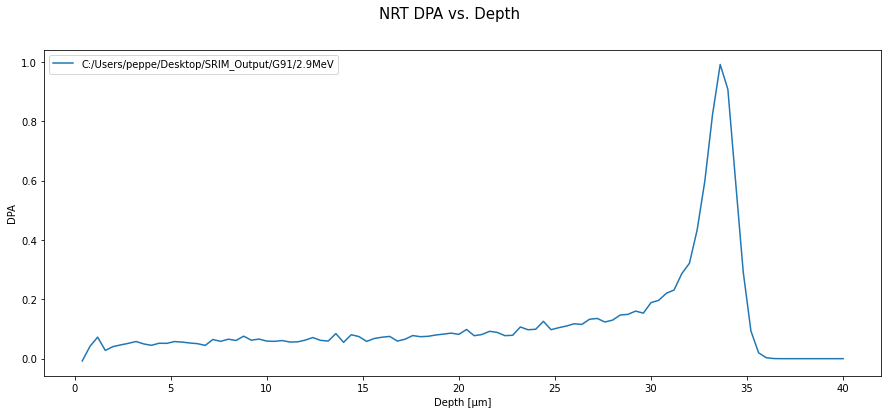

In [19]:
#fig, axes = plt.subplots(1, len(folders), sharex=True, sharey=True)
fig, axes = plt.subplots()

times = list(range(15, 30,15)) #list(range(1, 100))
for t in range(0,len(times)):
    for ax, folder in zip(np.ravel(axes), folders):
        time = times[t] #hours
        energy_damage = NRT(folder, ax, time)
        print("Damage energy: {} eV".format(energy_damage))
        ax.set_xlabel('Depth [µm]')
        ax.set_ylabel('DPA')
        ax.legend()

    fig.suptitle('NRT DPA vs. Depth', fontsize=15)
    fig.set_size_inches((15, 6))
    fig.savefig(os.path.join(image_directory, 'damagevsdepth.png'), transparent=True)

Max dpa: 1.08 at 33.6 µm, proton energy: 2.9 MeV, for 15 hours


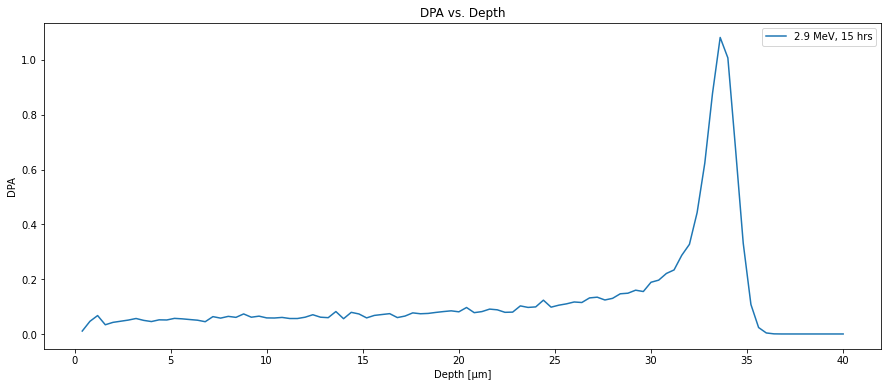

In [20]:
fig, ax = plt.subplots()

times = list(range(15, 30,15)) #list(range(1, 100))
for t in range(0,len(times)):
    for i, folder in enumerate(folders):
        time = times[t] #hours
        dpa_calc = plot_dpa(folder, ax, time)
        ax.plot(dpa_calc[0], dpa_calc[1], label=""+str(energies[i])+", "+str(time)+" hrs")
        index = np.where(dpa_calc[1] == max(dpa_calc[1]))
        a = dpa_calc[0][index]
        print("Max dpa: {} at {} µm, proton energy: {}, for {} hours".format( round(max(dpa_calc[1]),2),  str(a)[1:-1], energies[i], time))

    ax.set_xlabel('Depth [µm]') #Angstroms
    ax.set_ylabel('DPA')
    ax.set_title('DPA vs. Depth')
    ax.legend()
    fig.set_size_inches((15, 6))
    fig.savefig(os.path.join(image_directory, 'dpa_combined_auto_'+str(energies[i])+'.png'), transparent=False)

Max dpa: 1.08 at 33.6 µm, proton energy: 2.9 MeV, for 15 hours


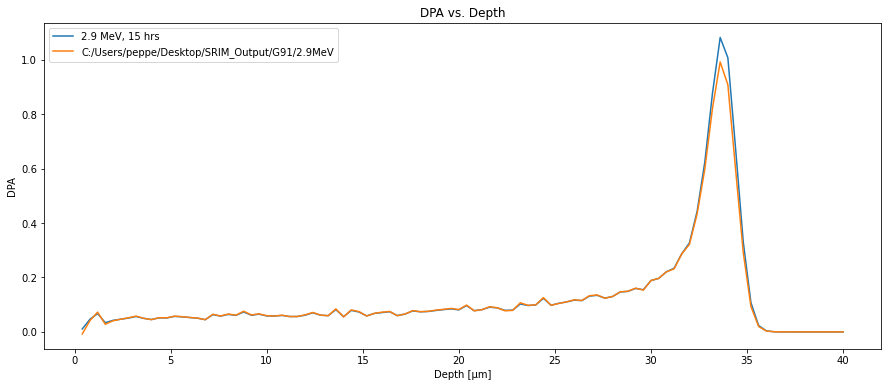

In [21]:
fig, ax = plt.subplots()

times = list(range(15, 30,15)) #list(range(1, 100))
for t in range(0,len(times)):
    for i, folder in enumerate(folders):
        time = times[t] #hours
        dpa_calc = plot_dpa(folder, ax, time)
        ax.plot(dpa_calc[0], dpa_calc[1], label=""+str(energies[i])+", "+str(time)+" hrs")
        index = np.where(dpa_calc[1] == max(dpa_calc[1]))
        a = dpa_calc[0][index]
        print("Max dpa: {} at {} µm, proton energy: {}, for {} hours".format( round(max(dpa_calc[1]),2),  str(a)[1:-1], energies[i], time))

        energy_damage = NRT(folder, ax, time)
        
    ax.set_xlabel('Depth [µm]') #Angstroms
    ax.set_ylabel('DPA')
    ax.set_title('DPA vs. Depth')
    ax.legend()
    fig.set_size_inches((15, 6))
    fig.savefig(os.path.join(image_directory, 'dpa_combined_auto_'+str(energies[i])+'.png'), transparent=False)